## This notebook is a demo of using fastai for a Kaggle competition
Assumes data is available in a `data` subdirectory. You can find the data [here](https://www.kaggle.com/c/bluebook-for-bulldozers/data). I suggest you use `kaggle-cli` to download the data.

In [47]:
# auto reload any changes in module

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [49]:
PATH = "data/"

In [50]:
!ls -ltr {PATH}

total 575768
-rwxr-xr-x@ 1 arm  staff  116403970 Jan 24  2013 Train.csv
-rwxr-xr-x@ 1 arm  staff     196760 Apr 28 12:21 median_benchmark.csv
-rwxr-xr-x@ 1 arm  staff    3318969 Apr 28 12:21 Valid.csv
-rwxr-xr-x@ 1 arm  staff    3560907 Apr 28 12:21 Test.csv
-rwxr-xr-x@ 1 arm  staff      11063 Apr 28 12:21 Data Dictionary.xlsx
-rwxr-xr-x@ 1 arm  staff  119791159 Apr 28 12:21 TrainAndValid.csv
-rwxr-xr-x@ 1 arm  staff   51498702 Apr 28 12:21 Machine_Appendix.csv


## Let's look into data

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

Train.csv is the training set, which contains data through the end of 2011.

Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

SalesID: the uniue identifier of the sale

MachineID: the unique identifier of a machine. A machine can be sold multiple times

saleprice: what the machine sold for at auction (only provided in train.csv)

saledate: the date of the sale

In [51]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [52]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [53]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df_raw.SalePrice

0         66000
1         57000
2         10000
3         38500
4         11000
5         26500
6         21000
7         27000
8         21500
9         65000
10        24000
11        22500
12        36000
13        30500
14        28000
15        19000
16        13500
17         9500
18        12500
19        11500
20        41000
21        34500
22        26000
23        73000
24        33000
25        12500
26        15500
27        53000
28        46000
29        89000
          ...  
401095    10500
401096    10000
401097     8500
401098    10500
401099    11000
401100    10500
401101    10000
401102    10500
401103    12500
401104    10500
401105    10000
401106    10500
401107    12500
401108    10500
401109    10500
401110    10500
401111    10000
401112    10500
401113    10500
401114    12500
401115    10000
401116     8500
401117    10000
401118     9500
401119     8500
401120    10500
401121    11000
401122    11500
401123     9000
401124     7750
Name: SalePrice, Length:

In [45]:
df_raw.SalePrice = np.log(df_raw.SalePrice).head()

In [58]:
min(df_raw.SalePrice)

4750

Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [59]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

This dataset contains a mix of continuous and categorical variables.

In [62]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [63]:
# use function add_datepart to replace a date variable with all of its date parts
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [64]:
# notice the new features generated by fastai add_datepart method
# this allows us to capture any trend/cyclical behavior as a function of time at any of these granularities.
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [65]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       401125 non-null object
ProductGroup               

In [66]:
# use function train_cats to convert strings to pandas categories (Notice: data type is not string, but category)
# pandas will continue displaying the text categories, while treating them as numerical data internally
train_cats(df_raw)

In [67]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null category
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGr

In [68]:
# you can specify categorical order if we choose 
df_raw.UsageBand.cat.categories
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [69]:
# look at ratio of missing values 
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [70]:
# save for later use
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [72]:
# preprocessing
df_raw = pd.read_feather('tmp/bulldozers-raw')

/Users/arm/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [73]:
min(df_raw.SalePrice)

8.465899897028686

In [74]:
# use function proc_df to replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.
df, y, nas = proc_df(df_raw, 'SalePrice')

In [76]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9830299504100178

In [78]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [79]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 22s, sys: 860 ms, total: 1min 23s
Wall time: 17.5 s
[0.090399943410889, 0.25063843044564865, 0.9829206576735854, 0.887812802702164]


we can see from the validation set score that we're over-fitting badly

In [81]:
# speed things up 
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [82]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.86 s, sys: 39.8 ms, total: 2.9 s
Wall time: 716 ms
[0.11645543577777252, 0.3484224931989262, 0.9706173163740945, 0.7831994686905779]


In [83]:
# let's look at a single tree to figure out why we're overfitting 
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5278248089182187, 0.5800279727196246, 0.3963968083351186, 0.3991779661086227]


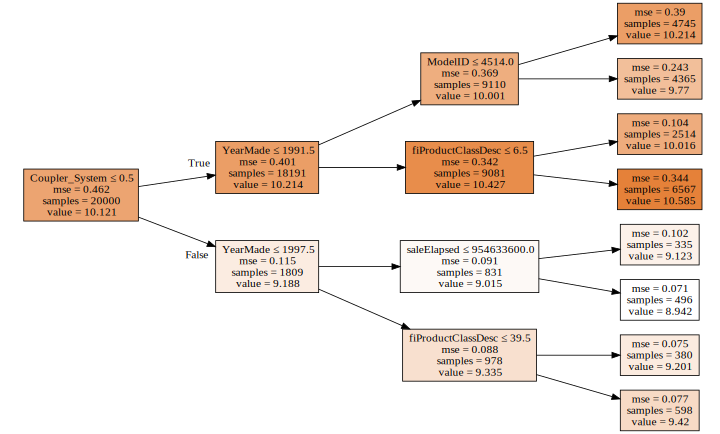

In [84]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [85]:
# let's use bagging
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11471825966643348, 0.3443995687505113, 0.9714873863717599, 0.7881769720200368]


In [87]:
# grab the predictions for each individual tree, and look at one example
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.43348, 9.51044, 9.04782, 9.21034, 9.43348, 9.39266, 9.95228, 9.04782, 9.25913, 8.92266]),
 9.321012454908601,
 9.104979856318357)

In [88]:
preds.shape

(10, 12000)

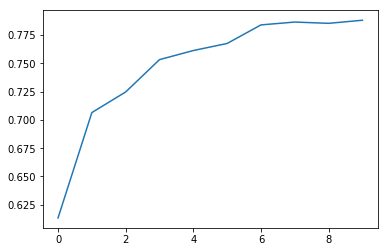

In [89]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. 

In [90]:
for num_trees in [20,40,80,100]:
    m = RandomForestRegressor(n_estimators=num_trees, n_jobs=-1)
    m.fit(X_train, y_train)
    print_score(m)

[0.10515568329092004, 0.3354622359522526, 0.9760427244147123, 0.799028141503997]
[0.09881359591066632, 0.33183436935595084, 0.9788453747121133, 0.8033514696304875]
[0.09666989535950252, 0.32755611237715165, 0.9797532916862507, 0.8083894621147419]
[0.09589561097907695, 0.32855539744131973, 0.9800763276859115, 0.8072185750001836]


## Out-of-bag (OOB) 
Is our validation set worse than our training set because we’re over-fitting, or because the validation set is for a different time period, or a bit of both? This trick works for small datasets.

The idea is to calculate error on the training set, but only include the trees in the calculation of a row’s error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

In [91]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09907110240068025, 0.33596139375557504, 0.9787349738864204, 0.7984296162766238, 0.8481201577579959]


Our validation set time difference is making an impact, as is model over-fitting. One of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: subsampling.

In [92]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [94]:
# limit it to a different random subset per tree 
# given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast 
set_rf_samples(20000)
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.52 s, sys: 638 ms, total: 10.2 s
Wall time: 4.88 s
[0.24148237467485112, 0.2813626955008959, 0.878127505062438, 0.8586222694656834, 0.8655089883284771]


since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [97]:
# try other ways of avoiding over-fitting
reset_rf_samples()

In [98]:
# baseline
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0783353549923571, 0.23746128503112066, 0.9871752042317434, 0.8992990421893179, 0.9084836002820498]


In [99]:
# reduce over-fitting by letting our trees grow less deeply
# this provides two benefits:
    # less decision rules for each leaf node; simpler models should generalize better
    # predictions are made by averaging more rows in the leaf node, resulting in less volatility
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11482700920909966, 0.23279591896946208, 0.972443571288028, 0.9032170848201523, 0.9088171985368613]


In [100]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11888739279177073, 0.22882746279999977, 0.9704602760705576, 0.9064886634314107, 0.9119938109845387]


In [103]:
val_predictions = m.predict(X_valid)

In [114]:
pd.Series(val_predictions)

0         9.239447
1         9.140613
2         9.170178
3         9.232220
4         9.090724
5         9.223673
6         9.324542
7         9.191314
8         9.383815
9         9.450783
10        9.297037
11        9.382080
12        9.578838
13        9.706642
14       10.737550
15        9.643225
16       10.076098
17       10.311721
18       10.440996
19        9.729562
20        9.510945
21        9.415065
22       10.687949
23        9.674833
24       10.759657
25       10.765024
26        9.586406
27        9.577233
28        9.522121
29        9.526858
           ...    
11970     9.246931
11971     9.266050
11972     9.381302
11973     9.278044
11974     9.235156
11975     9.278044
11976     9.235744
11977     9.294231
11978     9.325844
11979     9.294231
11980     9.347262
11981     9.294231
11982     9.325256
11983     9.294231
11984     9.294819
11985     9.325256
11986     9.347262
11987     9.347262
11988     9.347262
11989     9.287046
11990     9.347262
11991     9.

In [113]:
X_valid.SalesID.head()

389125    4364751
389126    4364757
389127    4364774
389128    4364807
389129    4364811
Name: SalesID, dtype: int64

In [116]:
submission = pd.concat([X_valid.SalesID, pd.Series(val_predictions)])

In [117]:
submission.to_csv("rf_submission.csv")

In [118]:
!head rf_submission.csv

389125,4364751.0
389126,4364757.0
389127,4364774.0
389128,4364807.0
389129,4364811.0
389130,4364833.0
389131,4364957.0
389132,4364977.0
389133,4364983.0
389134,4364984.0
